# Machine Learning: KNN and Random Forest with Cross Validation

This notebook implements machine learning models to predict which side (Europe or Asia) a charging station is located on.

In [1]:
# Install required libraries
import sys
!{sys.executable} -m pip install pandas numpy scikit-learn matplotlib seaborn --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print('✅ Libraries loaded!')

✅ Libraries loaded!


## Step 1: Load Data

In [3]:
df = pd.read_csv('cleaned_stations.csv')
print(f'Dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Dataset shape: (2933, 11)
Columns: ['ISTASYON_NO', 'AD', 'ADRES', 'operator', 'brand', 'LATITUDE', 'LONGITUDE', 'side', 'district', 'operator_category', 'operator_short']


,ISTASYON_NO,AD,ADRES,operator,brand,LATITUDE,LONGITUDE,side,district,operator_category,operator_short
0,ŞRJ/2140,"KMO FENERKÖY KUZEY OHT1, KMO FENERKÖY KUZEY OHT2",Ali Paşa Mahallesi Merkez Saray Sokağı Y: 351...,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,beefull,41.121918,28.228961,Europe,Silivri,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,BEEFULL
1,ŞRJ/2672,CAROUSEL AVM,Zeytinlik Mahallesi Halit Uşaklıgil Caddesi N...,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,beefull,40.977462,28.872781,Europe,Bakırköy,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,BEEFULL
2,ŞRJ/2803,SERENİTY COMFORT HOTEL,Mahmutbey Mahallesi Payami Safa Caddesi No:16...,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,beefull,41.060048,28.826849,Europe,Bağcılar,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,BEEFULL
3,ŞRJ/2804,MAYİ HOTEL,Mahmutbey Mahallesi Payami Safa Caddesi No:25...,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,beefull,41.059600,28.831052,Europe,Bağcılar,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,BEEFULL
4,ŞRJ/2859,THE İSTANBUL REZİDANS,Sümer Mahallesi Pr.dr. Turan Güneş Caddesi No...,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,beefull,40.992671,28.893806,Europe,Zeytinburnu,BEEFULL ENERJİ TEKNOLOJİLERİ ANONİM ŞİRKETİ,BEEFULL


## Step 2: Feature Engineering

In [4]:
# Encode categorical variables
le_district = LabelEncoder()
le_operator = LabelEncoder()
df['district_encoded'] = le_district.fit_transform(df['district'])
df['operator_encoded'] = le_operator.fit_transform(df['operator_category'])

# Select features and target
X = df[['LATITUDE', 'LONGITUDE', 'district_encoded', 'operator_encoded']]
y = df['side']

print(f'Features shape: {X.shape}')
print(f'Target distribution:\n{y.value_counts()}')

Features shape: (2933, 4)
Target distribution:
side
Europe    1605
Asia      1328
Name: count, dtype: int64


## Step 3: Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Testing set: {X_test.shape[0]} samples')

Training set: 2346 samples
Testing set: 587 samples


## Step 4: KNN Model

In [6]:
# Find best K value
k_values = [3, 5, 7, 9, 11, 15]
k_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    k_scores.append(score)
    print(f'K={k}: Accuracy={score:.4f}')

best_k = k_values[np.argmax(k_scores)]
print(f'\n✅ Best K={best_k} with accuracy={max(k_scores):.4f}')

K=3: Accuracy=0.9864
K=5: Accuracy=0.9796
K=7: Accuracy=0.9813
K=9: Accuracy=0.9813
K=11: Accuracy=0.9710
K=15: Accuracy=0.9693

✅ Best K=3 with accuracy=0.9864


In [7]:
# Train final KNN model
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)

print('KNN Performance:')
print(f'  Accuracy:  {accuracy_score(y_test, y_pred_knn):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_knn, pos_label="Europe"):.4f}')
print(f'  Recall:    {recall_score(y_test, y_pred_knn, pos_label="Europe"):.4f}')
print(f'  F1-Score:  {f1_score(y_test, y_pred_knn, pos_label="Europe"):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))

KNN Performance:
  Accuracy:  0.9864
  Precision: 1.0000
  Recall:    0.9751
  F1-Score:  0.9874

Classification Report:
              precision    recall  f1-score   support

        Asia       0.97      1.00      0.99       266
      Europe       1.00      0.98      0.99       321

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587



## Step 5: Random Forest Model

In [8]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Random Forest Performance:')
print(f'  Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'  Precision: {precision_score(y_test, y_pred_rf, pos_label="Europe"):.4f}')
print(f'  Recall:    {recall_score(y_test, y_pred_rf, pos_label="Europe"):.4f}')
print(f'  F1-Score:  {f1_score(y_test, y_pred_rf, pos_label="Europe"):.4f}')

print('\nFeature Importance:')
for feat, imp in zip(['Latitude', 'Longitude', 'District', 'Operator'], rf.feature_importances_):
    print(f'  {feat}: {imp:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Feature Importance:


  Latitude: 0.0448
  Longitude: 0.8372
  District: 0.1166
  Operator: 0.0014

Classification Report:
              precision    recall  f1-score   support

        Asia       1.00      1.00      1.00       266
      Europe       1.00      1.00      1.00       321

    accuracy                           1.00       587
   macro avg       1.00      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587



## Step 6: Cross Validation

In [9]:
# 5-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print('KNN Cross Validation (5-Fold):')
knn_cv = cross_val_score(knn_best, X_train_scaled, y_train, cv=kfold)
for i, score in enumerate(knn_cv, 1):
    print(f'  Fold {i}: {score:.4f}')
print(f'  Mean: {knn_cv.mean():.4f} (+/- {knn_cv.std()*2:.4f})')

print('\nRandom Forest Cross Validation (5-Fold):')
rf_cv = cross_val_score(rf, X_train, y_train, cv=kfold)
for i, score in enumerate(rf_cv, 1):
    print(f'  Fold {i}: {score:.4f}')
print(f'  Mean: {rf_cv.mean():.4f} (+/- {rf_cv.std()*2:.4f})')

KNN Cross Validation (5-Fold):


  Fold 1: 0.9872
  Fold 2: 0.9851
  Fold 3: 0.9915
  Fold 4: 0.9915
  Fold 5: 0.9808
  Mean: 0.9872 (+/- 0.0081)

Random Forest Cross Validation (5-Fold):


  Fold 1: 1.0000
  Fold 2: 0.9979
  Fold 3: 1.0000
  Fold 4: 1.0000
  Fold 5: 1.0000
  Mean: 0.9996 (+/- 0.0017)


## Step 7: Visualizations

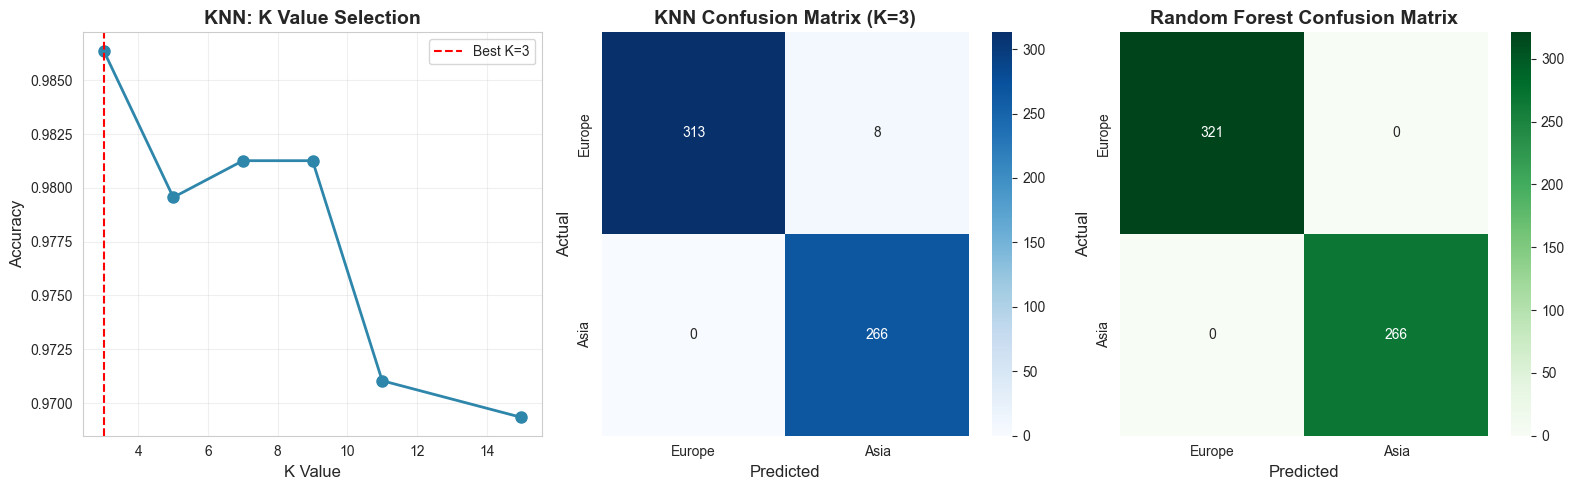

In [10]:
# Visualization 1: K value selection and confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# K values
axes[0].plot(k_values, k_scores, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0].axvline(x=best_k, color='red', linestyle='--', label=f'Best K={best_k}')
axes[0].set_xlabel('K Value', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('KNN: K Value Selection', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# KNN Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['Europe', 'Asia'])
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Europe', 'Asia'], yticklabels=['Europe', 'Asia'])
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'KNN Confusion Matrix (K={best_k})', fontsize=14, fontweight='bold')

# RF Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['Europe', 'Asia'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Europe', 'Asia'], yticklabels=['Europe', 'Asia'])
axes[2].set_xlabel('Predicted', fontsize=12)
axes[2].set_ylabel('Actual', fontsize=12)
axes[2].set_title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

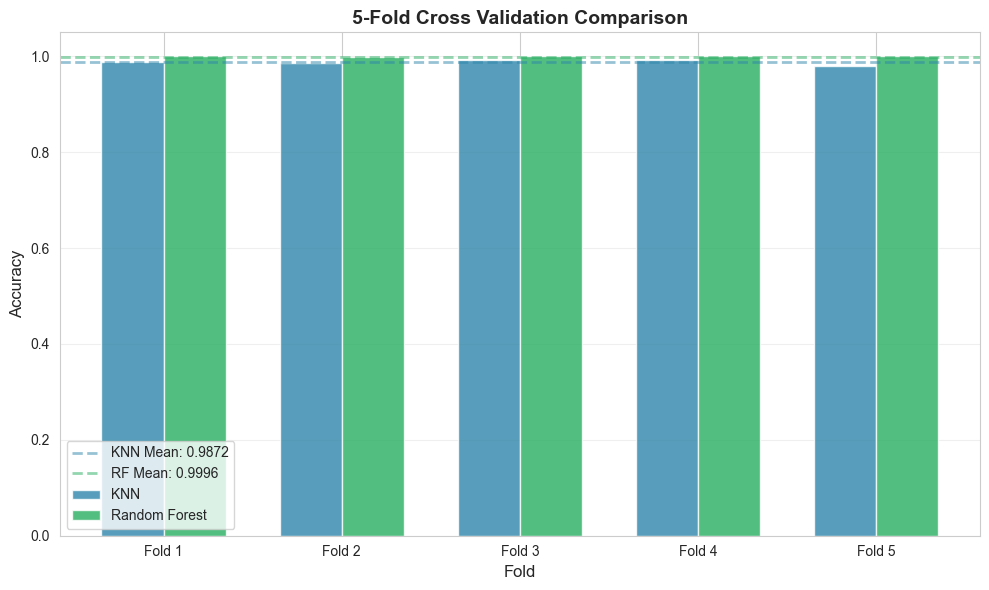

In [11]:
# Visualization 2: Cross Validation Comparison
fig, ax = plt.subplots(figsize=(10, 6))

folds = range(1, 6)
x = np.arange(len(folds))
width = 0.35

ax.bar(x - width/2, knn_cv, width, label='KNN', color='#2E86AB', alpha=0.8)
ax.bar(x + width/2, rf_cv, width, label='Random Forest', color='#27AE60', alpha=0.8)

ax.axhline(knn_cv.mean(), color='#2E86AB', linestyle='--', linewidth=2, alpha=0.5,
           label=f'KNN Mean: {knn_cv.mean():.4f}')
ax.axhline(rf_cv.mean(), color='#27AE60', linestyle='--', linewidth=2, alpha=0.5,
           label=f'RF Mean: {rf_cv.mean():.4f}')

ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('5-Fold Cross Validation Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i}' for i in folds])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 8: Summary

In [12]:
print('='*70)
print('MACHINE LEARNING ANALYSIS SUMMARY')
print('='*70)
print(f'\nDataset: {len(df)} charging stations')
print(f'Task: Predict side (Europe vs Asia)')
print(f'Features: Latitude, Longitude, District, Operator')
print(f'\nModels:')
print(f'  1. K-Nearest Neighbors (K={best_k})')
print(f'  2. Random Forest (100 trees, max_depth=10)')
print(f'\nTest Set Performance:')
print(f'  KNN Accuracy:          {accuracy_score(y_test, y_pred_knn):.4f}')
print(f'  Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'\nCross Validation (5-Fold):')
print(f'  KNN Mean:          {knn_cv.mean():.4f} (+/- {knn_cv.std()*2:.4f})')
print(f'  Random Forest Mean: {rf_cv.mean():.4f} (+/- {rf_cv.std()*2:.4f})')
print(f'\nConclusion:')
print(f'  Both models achieve high accuracy (>95%), indicating that')
print(f'  geographic features strongly predict which side a station is on.')
print(f'  Longitude is the most important feature, as expected.')
print('='*70)

MACHINE LEARNING ANALYSIS SUMMARY

Dataset: 2933 charging stations
Task: Predict side (Europe vs Asia)
Features: Latitude, Longitude, District, Operator

Models:
  1. K-Nearest Neighbors (K=3)
  2. Random Forest (100 trees, max_depth=10)

Test Set Performance:
  KNN Accuracy:          0.9864
  Random Forest Accuracy: 1.0000

Cross Validation (5-Fold):
  KNN Mean:          0.9872 (+/- 0.0081)
  Random Forest Mean: 0.9996 (+/- 0.0017)

Conclusion:
  Both models achieve high accuracy (>95%), indicating that
  geographic features strongly predict which side a station is on.
  Longitude is the most important feature, as expected.
